# Single sample scATAC-seq pipeline with snapATAC2
**Author**: Adam Klie (last modified: 10/24/2023)<br>
***
**Description**: This script performs the standard single sample SnapATAC2 pipeline.

In [1]:
# Imports
import os
import time
import logging
import argparse
from tqdm.auto import tqdm
import snapatac2 as snap
import scanpy as sc
print(snap.__version__)
print(sc.__version__)

2.3.1
1.9.3


In [25]:
# Define paths

# I/O
frag_file = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/processed/23Oct23/chromap/MM168/aln.bed"
min_load_tsse = 4
sorted_by_barcode = False
min_load_num_fragments = 1000
chunk_size = 1000000
low_memory = False


# QC and filtering
min_tsse = 12
min_num_fragments = 2000
max_num_fragments = 50000

# Feature selection
bin_size = 5000
num_features = 50000

# Analysis
clustering_resolution = 1

# Output
output_prefix = "snap2_single_sample_pipeline"
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/MM168"

In [17]:
# If output directory does not exist, create it.
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

# Read fragment file

In [3]:
# Load in from fragment file into memory
adata = snap.pp.import_data(
    fragment_file=frag_file,
    genome=snap.genome.hg38,
    min_tsse=min_load_tsse,
    min_num_fragments=min_load_num_fragments,
    sorted_by_barcode=sorted_by_barcode,
    chunk_size=chunk_size,
    low_memory=low_memory,
)

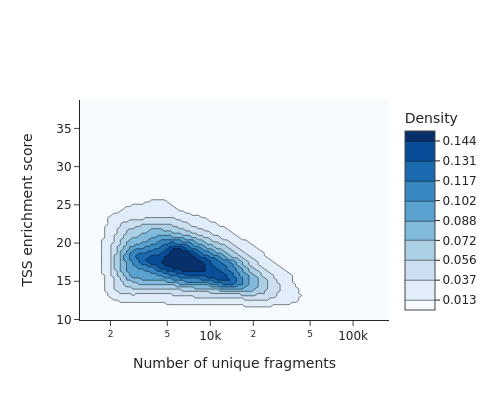

In [4]:
# Plot TSSe distribution vs number of fragments
snap.pl.tsse(adata, interactive=False)

# QC and filtering

In [10]:
# Filter out low quality cells
snap.pp.filter_cells(adata, min_tsse=min_tsse, min_counts=min_num_fragments, max_counts=max_num_fragments)

In [11]:
# Add a 5kb tile matrix
snap.pp.add_tile_matrix(adata, bin_size=bin_size)

In [12]:
# Select the top accessible features
snap.pp.select_features(adata, n_features=num_features)

2023-10-24 09:55:45 - INFO - Selected 50000 features.


In [13]:
# Run scrublet
snap.pp.scrublet(adata)

In [15]:
# Filter out doublets
snap.pp.filter_doublets(adata)

2023-10-24 10:02:04 - INFO - Detected doublet rate = 7.063%


In [19]:
# Save the processed data
adata.write(os.path.join(outdir_path, f"qc.h5ad"))

# Dimensionality reduction and clustering

In [20]:
# Run the spectral embedding
snap.tl.spectral(adata)

In [22]:
# Run UMAP
snap.tl.umap(adata)

In [23]:
# Find nearest neighbor graph
snap.pp.knn(adata, use_rep="X_spectral")

In [26]:
# Cluster data
snap.tl.leiden(adata, resolution=clustering_resolution)

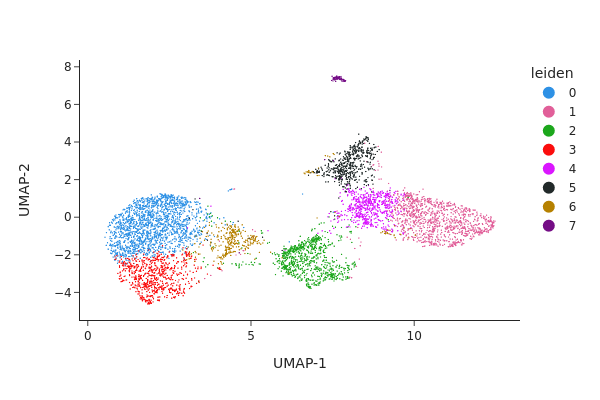

In [27]:
# Plot the UMAP with clusters
snap.pl.umap(adata, color="leiden", interactive=False)

In [28]:
# Save updated data
adata.write(os.path.join(outdir_path, f"clustered.h5ad"))

... storing 'leiden' as categorical


# Gene activity

In [29]:
# Create a gene matrix
gene_matrix = snap.pp.make_gene_matrix(
    adata=adata,
    gene_anno=snap.genome.hg38
)

In [30]:
# Clean up the gene matrix
sc.pp.filter_genes(gene_matrix, min_cells=3)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

In [31]:
# Run MAGIC
sc.external.pp.magic(gene_matrix, solver="approximate")

In [32]:
# Transfer the UMAP from the original data to the gene matrix
gene_matrix.obsm["X_umap"] = adata.obsm["X_umap"]

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



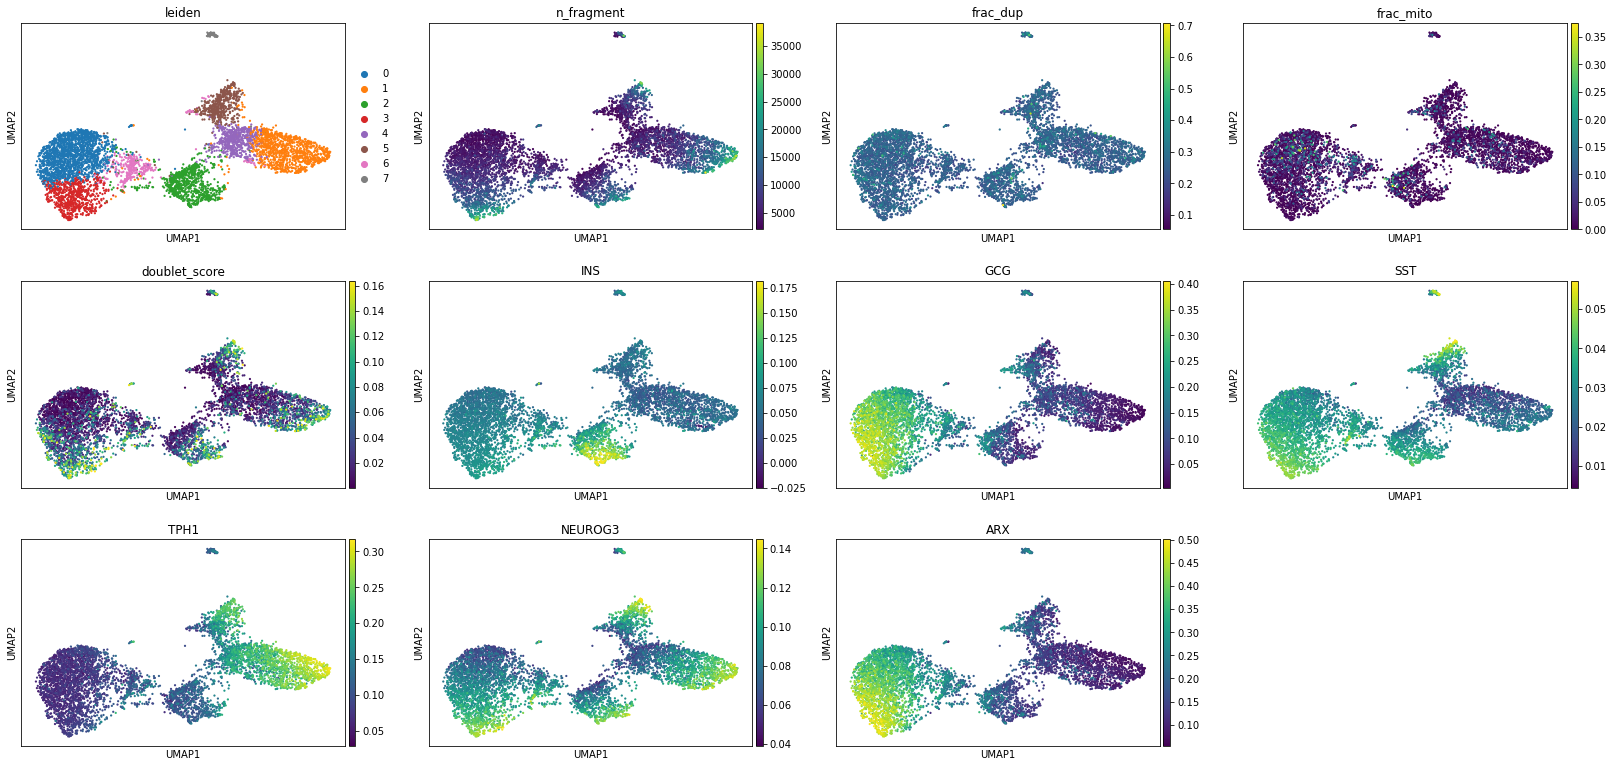

In [35]:
# Plot some technical covariates and marker genes
marker_genes = ['INS', 'GCG', 'SST', 'TPH1', 'NEUROG3', 'ARX']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden", "n_fragment", "frac_dup", "frac_mito", "doublet_score"] + marker_genes)

In [34]:
# Save the gene matrix
gene_matrix.write(os.path.join(outdir_path, f"gene_matrix.h5ad"))

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


# DONE!

---